In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Tenv = torch.tensor([20.0], device=DEVICE)  # ambient temperature
R = 0.01                                     # known cooling constant
T0 = 100.0                                   # initial temperature

In [3]:
# model definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    
    def forward(self, t):
        return self.net(t)


In [4]:
# physics loss
def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs,
        inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True
    )

def physics_loss_with_ic(model):
    ts = torch.linspace(0, 500, steps=1000).view(-1, 1).to(DEVICE).requires_grad_(True)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    ode = dT - R * (Tenv - temps)
    loss_f =  torch.mean(ode ** 2)

    # Initial condition at t = 0
    t0 = torch.tensor([[0.0]], device=DEVICE).requires_grad_(True)
    T0_pred = model(t0)
    loss_u = (T0_pred - T0) ** 2

    return loss_f + loss_u

In [5]:
# training
def train(model, lr=1e-3, epochs=5000):
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = physics_loss_with_ic(model)
        loss.backward()
        optimizer.step()

In [6]:
# plotting
def plot_solution(model):
    model.eval()
    with torch.no_grad():
        # Collocation points
        ts = torch.linspace(0, 500, steps=50).view(-1, 1).to(DEVICE)
        predicted = model(ts).cpu().squeeze()
    
    # Analytic solution
    t_np = ts.cpu().numpy().squeeze()
    analytic = Tenv.item() + (T0 - Tenv.item()) * np.exp(-R * t_np)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(t_np, analytic, label=f"Analytic Solution (R={R})", linewidth=2)
    plt.plot(t_np, predicted, '--', label="PINN Prediction", color='red')

    # Highlight collocation points as vertical dotted lines or scatter points
    #plt.scatter(t_np, predicted.detach().numpy(), s=5, c='red', alpha=0.3, label="Collocation Points")

    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.title("Newton's Law of Cooling: PINN vs Analytic")
    plt.legend()
    plt.grid(True)
    plt.show()

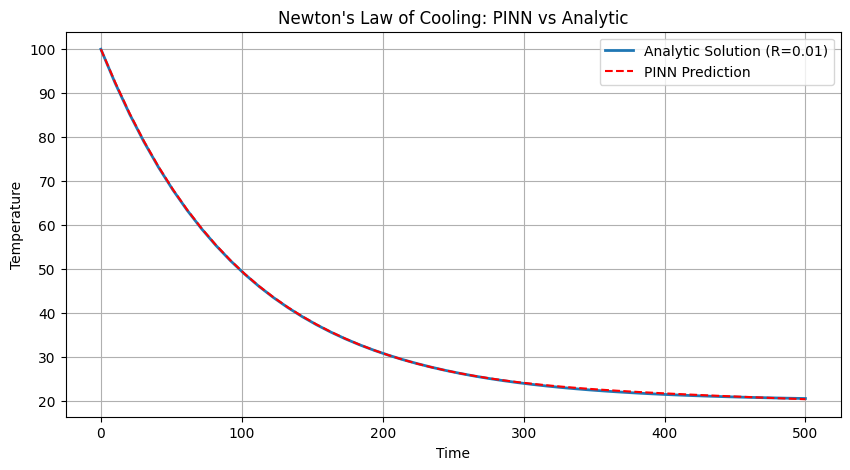

In [7]:
model = Net()
train(model)
plot_solution(model)